# Exploratory data analysis

#### Testing new fall cooling definition

In [1]:
import compute_yearly_risk as main
import numpy as np
import matplotlib.pyplot as plt


arr = np.array([
    -4, -3, -12.398916, -8., -5., -5.5, -5., -5.5, -10., -9., -7., -8.5, -12.83784,
    -11., -15.83784, -19., -21., -19.5, -18., -12.81168, -13.5, -19.5, -25., -20, -18, -3
])
print("Example 1 (Fairbanks 2009: ", main.fall_survival(arr))

arr = np.array([
    -4, -3, -12.5     , -16.5     , -20.5     , -22.      , -20.5     ,
    -15.5     , -12.      , -15.      , -14.      , -10.5     ,
    -15.5     , -19.220118, -22.      , -19.5     , -25.5     ,
    -19.      , -22.      , -24.220118, -29.      , -29.      ,
    -31.5, -20, -18, -3
])
print("Example 2 (Glenallen 2009: ", main.fall_survival(arr))


Example 1 (Fairbanks 2009:  0.84
Example 2 (Glenallen 2009:  0.19


### Validating fall cooling - Glenallen and Fairbanks

Seeing some weirdness in the current implementation of the algorithm (8/25/2022) such as really cold winters and autumns for Glenallen relative to Fairbanks. Want to manually extract and make sure things are looking correct.

In [113]:

years = list(range(2009, 2014))
locations_lu = {
    "Fairbanks": {
        "latlon": (64.8401, -147.7200),
    },
    "Glenallen": {
        "latlon": (62.1081, -145.5340),
    }
}

def latlon_to_idx(da, lat, lon):
    if da["longitude"].values.max() > 0:
        # create new longitude array for point extraction that 
        #  is on the [-360, 0) scale in case it's not
        new_lon = da["longitude"].values.copy()
        new_lon[new_lon > 0] = new_lon[new_lon > 0] - 360
    else:
        new_lon = ds["longitude"].values
    
    dist_arr = np.sqrt(
        np.square(new_lon - lon) + np.square(da["latitude"] - lat)
    ).values

    yidx, xidx = np.where(dist_arr == dist_arr.min())
    
    return yidx, xidx

In [114]:
from pathlib import Path
import numpy as np
import xarray as xr

met_dir = Path("/Data/Base_Data/Climate/AK_NCAR_12km/met")

with xr.open_dataset(met_dir.joinpath("daymet", f"daymet_met_2000.nc")) as temp_ds:
    for location in locations_lu:
        locations_lu[location]["yx"] = latlon_to_idx(
            temp_ds, *locations_lu[location]["latlon"]
        )
        locations_lu[location]["sel_di"] = {
            "y": locations_lu[location]["yx"][0],
            "x": locations_lu[location]["yx"][1],
        }

df_list = []
with xr.open_mfdataset([met_dir.joinpath("daymet", f"daymet_met_{year}.nc") for year in years]) as ds:
    for location in locations_lu:
        da = ds["tmin"].sel(time=slice("2009-09-01", "2009-12-31"), **locations_lu[location]["sel_di"])
        df = da.to_dataframe().reset_index()[["time", "tmin"]]
        df["location"] = location
        df_list.append(df)

df = pd.concat(df_list)

location
Fairbanks    AxesSubplot(0.125,0.2;0.775x0.68)
Glenallen    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

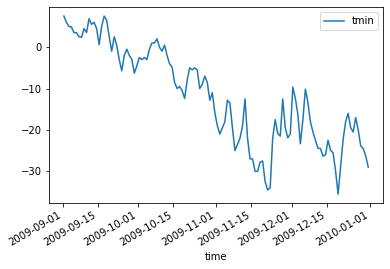

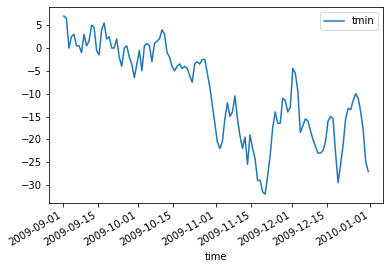

In [115]:
df.groupby("location").plot(x="time")

In [116]:
# current fall survival definition at time of this investigation
def fall_survival(arr):
    """Execute the fall survival algorithm for an
    array of temperature minimums for a single year.
    """
    try:
        idx = np.where(arr <= -12)[0][0]
    except IndexError:
        if np.isnan(arr[0]):
            return np.nan
        else:
            return 1.0

    window = arr[idx : idx + 21]
    # return 0 if tmin is ever less than -30
    if window.min() < -30:
        return 0.01
    # cooling cutoff values
    thr_arr = np.arange(-12, -32.5, -1)
    dd = thr_arr - window
    # count only positive values and sum
    dd = dd[dd > 0].sum()
    # ensure value is between 1 and 100
    fall_survival = np.clip(100 - (dd * 4.76), 1, 100)

    return round(fall_survival / 100, 2)


In [139]:
test = df[df["location"] == "Fairbanks"]["tmin"].values
print("Survival", fall_survival(test))
idx = np.where(test <= -12)[0][0]
print("cooling window:")
window = test[idx:idx + 21]
print(window)
thr_arr = np.arange(-12, -32.5, -1)
dd = thr_arr - window
print("DD:\n", dd)
dd = dd[dd > 0].sum()
print("Accum DD: ", dd)

Survival 0.98
cooling window:
[-12.398916  -8.        -5.        -5.5       -5.        -5.5
 -10.        -9.        -7.        -8.5      -12.83784  -11.
 -15.83784  -19.       -21.       -19.5      -18.       -12.81168
 -13.5      -19.5      -25.      ]
DD:
 [  0.39891624  -5.          -9.          -9.5        -11.
 -11.5         -8.         -10.         -13.         -12.5
  -9.16215992 -12.          -8.16215992  -6.          -5.
  -7.5        -10.         -16.18832016 -16.5        -11.5
  -7.        ]
Accum DD:  0.39891624450683594


In [140]:
test = df[df["location"] == "Glenallen"]["tmin"].values
print("Survival", fall_survival(test))
idx = np.where(test <= -12)[0][0]
print("cooling window:")
window = test[idx:idx + 21]
print(window)
thr_arr = np.arange(-12, -32.5, -1)
dd = thr_arr - window
print("DD:\n", dd)
dd = dd[dd > 0].sum()
print("Accum DD: ", dd)

Survival 0.01
cooling window:
[-12.5      -16.5      -20.5      -22.       -20.5      -15.5
 -12.       -15.       -14.       -10.5      -15.5      -19.220118
 -22.       -19.5      -25.5      -19.       -22.       -24.220118
 -29.       -29.       -31.5     ]
DD:
 [  0.5          3.5          6.5          7.           4.5
  -1.5         -6.          -4.          -6.         -10.5
  -6.5         -3.77988243  -2.          -5.5         -0.5
  -8.          -6.          -4.77988243  -1.          -2.
  -0.5       ]
Accum DD:  22.0


Yep, these values match the current extracted values. Looks like Glenallen just gets really cold sometimes, and fast, at that. 

## Validating risk components (Daymet)

Here we validate the components derived from the algorithms separately from the main processing code. We will extract data for a single grid cell and time slice of the Daymet data.

#### Fall cooling

In [3]:
from pathlib import Path
import xarray as xr


scratch_dir = Path("/atlas_scratch/kmredilla/beetles")
daymet_comp_fp = scratch_dir.joinpath("yearly_risk_components_daymet.nc")
with xr.open_dataset(daymet_comp_fp) as ds:
    pass

In [10]:
ds["fall_survival"].sel(y=104, x=150)

<xarray.DataArray 'fall_survival' (model: 1, scenario: 1, year: 38)>
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]]])
Coordinates:
  * year       (year) int64 1980 1981 1982 1983 1984 ... 2014 2015 2016 2017
  * model      (model) object 'daymet'
  * scenario   (scenario) float64 nan
    longitude  float32 -149.8
    latitude   float32 64.0

Load daymet dataset:

In [21]:
met_dir = Path("/Data/Base_Data/Climate/AK_NCAR_12km/met")

with xr.open_mfdataset([met_dir.joinpath("daymet", f"daymet_met_{year}.nc") for year in ["1980", "1981", "1982"]]) as ds:
    tmin = ds["tmin"].sel(y=104, x=150, time=slice("1980-01-01", "1980-12-31"))

In [22]:
import compute_yearly_risk as main


main.fall_survival(tmin)

0

## Visualizing risk dataset

Some exploration of the output risk dataset being created in this repo.

In [ ]:
# saved for plotting side-by-side pots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for arr, ax in zip(arrs, axes):
    im = ax.imshow(arr, interpolation="none")
    ax.set_title(f"plot title")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('cbar label', size=14, rotation=0)

plt.suptitle("fig title", size=14)
plt.show()

## NCAR Data

Some exploration of the NCAR BCSD data.

### Model-observed data comparisons

This section will compare the station data accessed by Nancy with the Daymet and CMIP model data in the NCAR dataset.

Get xy values for Fairbanks and Talkeetna for point extractions of the daymet data:

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr


met_dir = Path("/Data/Base_Data/Climate/AK_NCAR_12km/met")


locations_lu = {
    "Talkeetna": {
        "years": list(range(2012, 2018)),
        "latlon": (62.3209, -150.1066),
    },
    "Fairbanks": {
        "years": list(range(2014, 2020)),
        "latlon": (64.8401, -147.7200),
    },
}


def latlon_to_idx(da, lat, lon):
    if da["longitude"].values.max() > 0:
        # create new longitude array for point extraction that 
        #  is on the [-360, 0) scale in case it's not
        new_lon = da["longitude"].values.copy()
        new_lon[new_lon > 0] = new_lon[new_lon > 0] - 360
    else:
        new_lon = ds["longitude"].values
    
    dist_arr = np.sqrt(
        np.square(new_lon - lon) + np.square(da["latitude"] - lat)
    ).values

    yidx, xidx = np.where(dist_arr == dist_arr.min())
    
    return yidx[0], xidx[0]


def extract_dataframe(ds, varname, model, location, y, x, dates):
    """Extract values from the netCDF data into a dataframe"""
    var_model = f"{varname}_{model}"
    df = (
        ds[varname]
        .sel(y=y, x=x, time=dates)
        .to_dataframe()
        .reset_index()
        .rename(columns={varname: var_model, "time": "date"})
    # adding this to drop lat/lon columns that are included with CMIP data
    )[["date", var_model]]
    
    df["location"] = location

    return df


with xr.open_dataset(met_dir.joinpath("daymet", f"daymet_met_2000.nc")) as temp_ds:
    for location in locations_lu:
        locations_lu[location]["yx"] = latlon_to_idx(
            temp_ds, *locations_lu[location]["latlon"]
        ) 

Read in the observed station data for Fairbanks and Talkeetna:

In [2]:
import pandas as pd

obs_df = pd.read_csv("/workspace/Shared/Tech_Projects/beetles/project_data/fairbanks_talkeetna_t_export.csv", parse_dates=["date"])
obs_df["date"] = obs_df["date"] + np.timedelta64(12, "h")
# no 2018 data for daymet
obs_df = obs_df.set_index("date").loc[:"2017-12-31"].reset_index()

Extract data for point locations and organize into a dataframe:

In [ ]:
from pathlib import Path


with xr.open_mfdataset([met_dir.joinpath("daymet", f"daymet_met_{year}.nc") for year in range(2009, 2018)]) as ds:
    tmin_df_list = []
    tmax_df_list = []
    for location in locations_lu:
    # for location in ["Talkeetna"]:
        dates = obs_df[obs_df["location"] == location]["date"].values
        y, x = locations_lu[location]["yx"]
        tmin_df_list.append(extract_dataframe(ds, "tmin", "daymet", location, y, x, dates))
        tmax_df_list.append(extract_dataframe(ds, "tmax", "daymet", location, y, x, dates))

obs_df = obs_df.set_index(["date", "location"]).join(pd.concat(tmin_df_list).set_index(["date", "location"]))
obs_df = obs_df.join(pd.concat(tmax_df_list).set_index(["date", "location"])).reset_index()
obs_df["tmin_diff"] = obs_df["tmin"] - obs_df["tmin_daymet"]
obs_df["tmax_diff"] = obs_df["tmax"] - obs_df["tmax_daymet"]

#### Minimum temperature comparison

<AxesSubplot:title={'center':'Talkeetna'}, xlabel='date'>

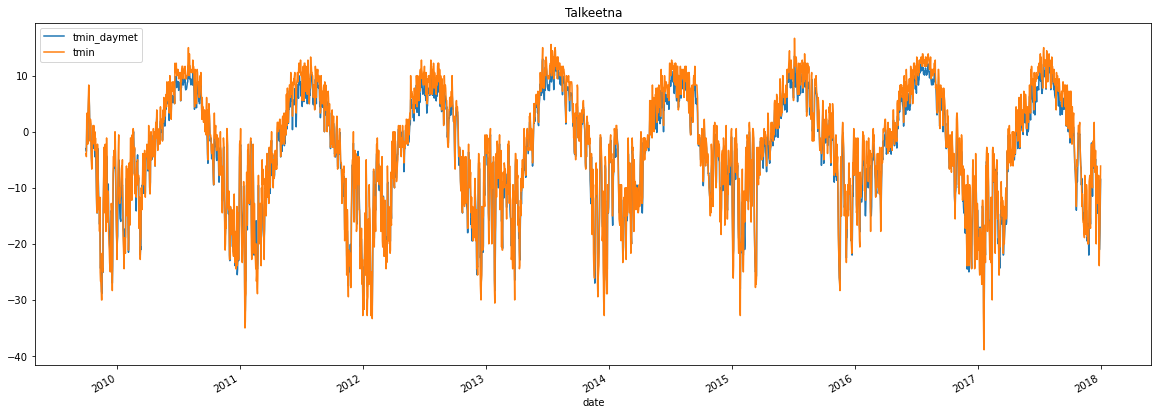

In [141]:
obs_df[obs_df["location"] == "Talkeetna"][["date", "tmin_daymet", "tmin"]].plot(x="date", figsize=(20, 7), title="Talkeetna")

<AxesSubplot:title={'center':'Talkeetna, tmin - tmin_daymet'}, xlabel='date'>

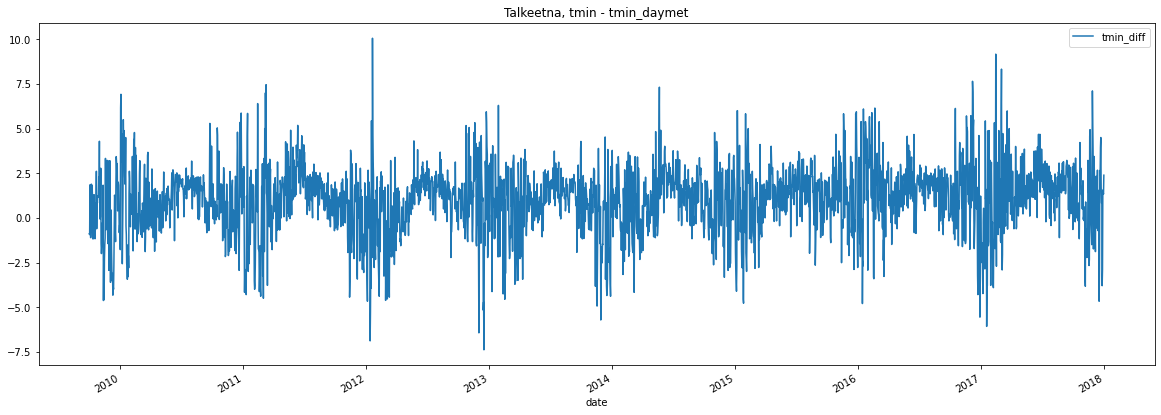

In [142]:
obs_df[obs_df["location"] == "Talkeetna"].plot(x="date", y="tmin_diff", figsize=(20, 7), title="Talkeetna, tmin - tmin_daymet")

<AxesSubplot:title={'center':'Fairbanks'}, xlabel='date'>

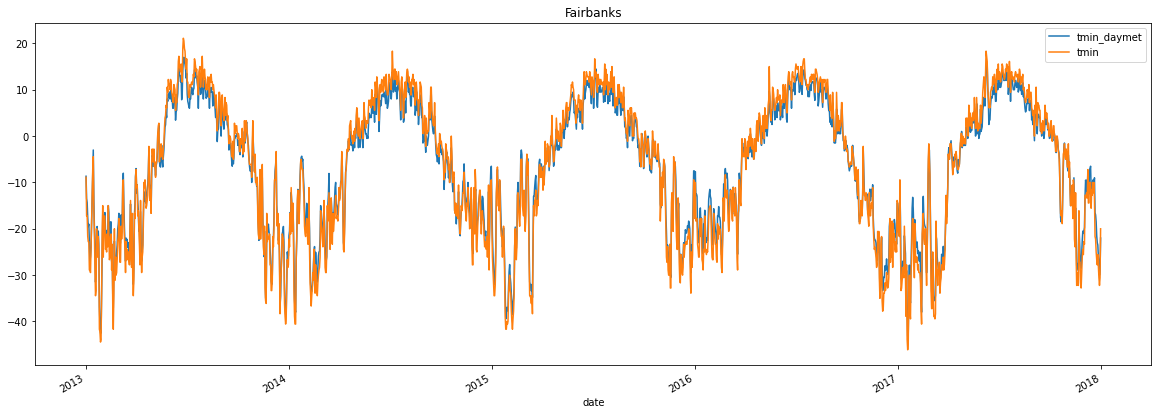

In [143]:
obs_df[obs_df["location"] == "Fairbanks"][["date", "tmin_daymet", "tmin"]].plot(x="date", figsize=(20, 7), title="Fairbanks")

<AxesSubplot:title={'center':'Fairbanks, tmin - tmin_daymet'}, xlabel='date'>

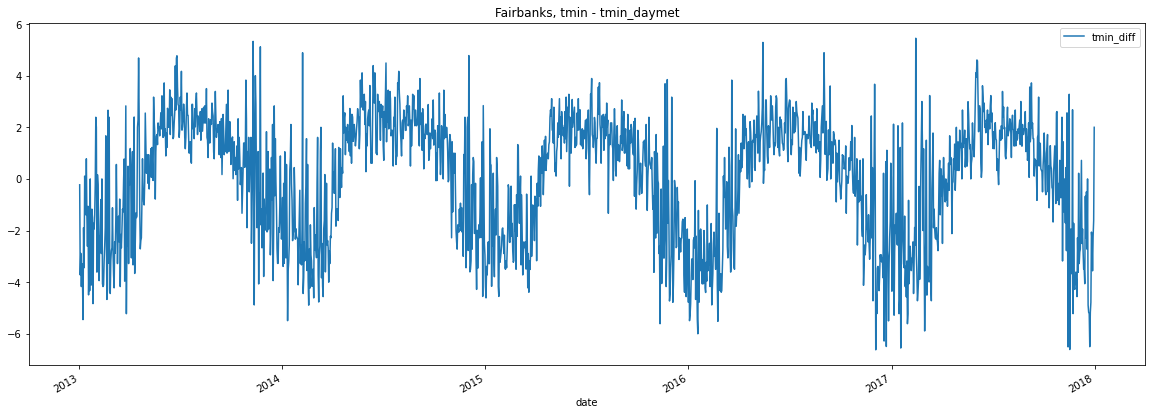

In [144]:
obs_df[obs_df["location"] == "Fairbanks"].plot(x="date", y="tmin_diff", figsize=(20, 7), title="Fairbanks, tmin - tmin_daymet")

How many days per year have differences greater than 2 and -2?

In [177]:
vals = [(obs_df.query("location == 'Talkeetna'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmin_diff"] > 2).sum() for year in range(2010, 2018)]
print(vals)
np.mean(vals)

[89, 95, 83, 80, 96, 106, 138, 133]


102.5

In [178]:
vals = [(obs_df.query("location == 'Talkeetna'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmin_diff"] < -2).sum() for year in range(2010, 2018)]
print(vals)
np.mean(vals)

[11, 33, 34, 34, 13, 17, 14, 26]


22.75

In [179]:
vals = [(obs_df.query("location == 'Fairbanks'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmin_diff"] > 2).sum() for year in range(2013, 2018)]
print(vals)
np.mean(vals)

[93, 106, 64, 58, 61]


76.4

In [180]:
vals = [(obs_df.query("location == 'Fairbanks'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmin_diff"] < -2).sum() for year in range(2013, 2018)]
print(vals)
np.mean(vals)

[70, 82, 89, 97, 95]


86.6

In [185]:
(365 - (87 + 76)) / 365 * 100

55.342465753424655

#### Maximum temperature comparison

<AxesSubplot:title={'center':'Talkeetna'}, xlabel='date'>

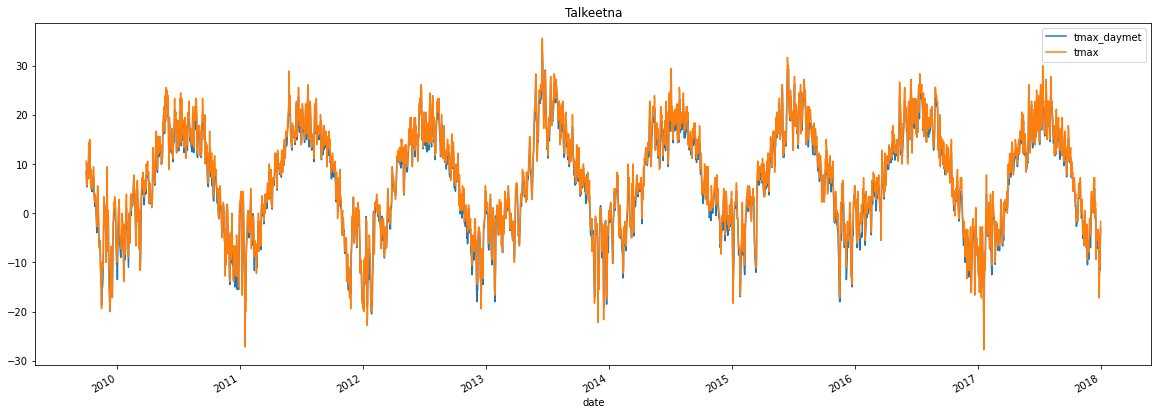

In [187]:
obs_df[obs_df["location"] == "Talkeetna"][["date", "tmax_daymet", "tmax"]].plot(x="date", figsize=(20, 7), title="Talkeetna")

<AxesSubplot:title={'center':'Talkeetna, tmax - tmax_daymet'}, xlabel='date'>

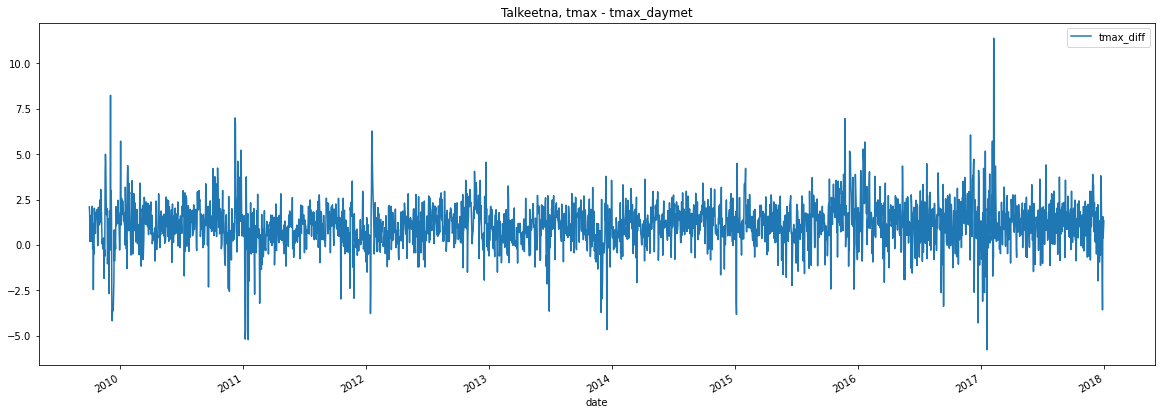

In [188]:
obs_df[obs_df["location"] == "Talkeetna"].plot(x="date", y="tmax_diff", figsize=(20, 7), title="Talkeetna, tmax - tmax_daymet")

<AxesSubplot:title={'center':'Fairbanks'}, xlabel='date'>

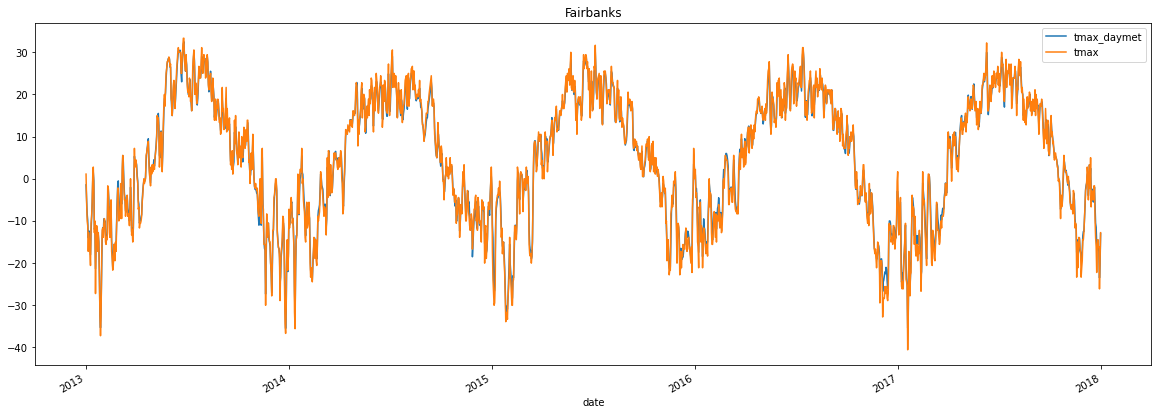

In [189]:
obs_df[obs_df["location"] == "Fairbanks"][["date", "tmax_daymet", "tmax"]].plot(x="date", figsize=(20, 7), title="Fairbanks")

<AxesSubplot:title={'center':'Fairbanks, tmax - tmax_daymet'}, xlabel='date'>

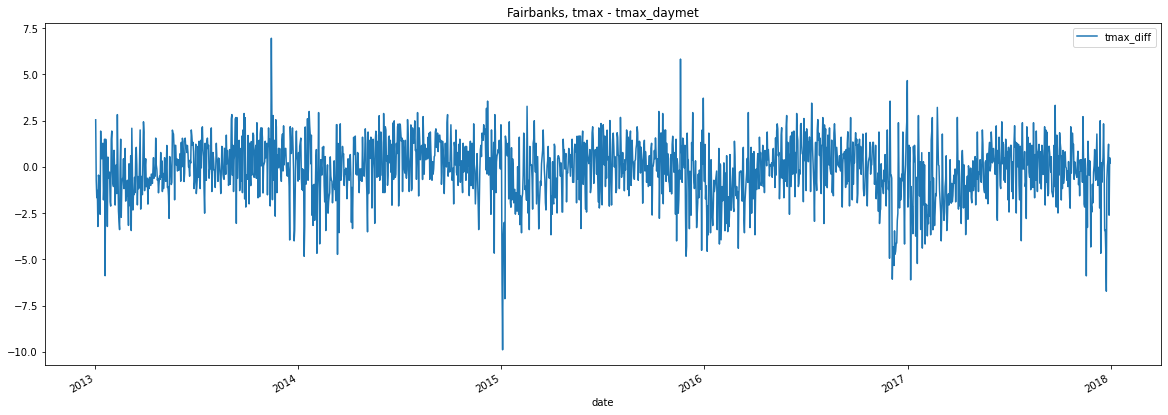

In [190]:
obs_df[obs_df["location"] == "Fairbanks"].plot(x="date", y="tmax_diff", figsize=(20, 7), title="Fairbanks, tmax - tmax_daymet")

How many days per year have differences greater than 2 and -2?

In [191]:
vals = [(obs_df.query("location == 'Talkeetna'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmax_diff"] > 2).sum() for year in range(2010, 2018)]
print(vals)
np.mean(vals)

[82, 29, 64, 48, 57, 81, 107, 80]


68.5

In [192]:
vals = [(obs_df.query("location == 'Talkeetna'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmax_diff"] < -2).sum() for year in range(2010, 2018)]
print(vals)
np.mean(vals)

[3, 9, 2, 6, 1, 5, 5, 5]


4.5

In [193]:
vals = [(obs_df.query("location == 'Fairbanks'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmax_diff"] > 2).sum() for year in range(2013, 2018)]
print(vals)
np.mean(vals)

[26, 36, 15, 24, 16]


23.4

In [194]:
vals = [(obs_df.query("location == 'Fairbanks'").set_index(["date"]).loc[f"{year}-01-01": f"{year}-12-31"]["tmax_diff"] < -2).sum() for year in range(2013, 2018)]
print(vals)
np.mean(vals)

[26, 23, 44, 51, 64]


41.6

### CMIP model historical-observed comparisons

This section will perform similar analysis as above but using the CMIP5 model data instead of the Daymet data.

Load observed data:

In [3]:
# load the observed data again
import pandas as pd

obs_df = pd.read_csv("/workspace/Shared/Tech_Projects/beetles/project_data/fairbanks_talkeetna_t_export.csv", parse_dates=["date"])
# no time delta for this one bc model timestamps are not noon like Daymet were
obs_df["date"] = obs_df["date"]
# no 2018 data for daymet
obs_df = obs_df.set_index("date").loc[:"2017-12-31"].reset_index()

Extract data for point locations and organize into a dataframe:

In [4]:
model = "CCSM4"
scenario = "rcp45"

for model in ["CCSM4", "GFDL-ESM2M"]:
    with xr.open_mfdataset([met_dir.joinpath(model, scenario, f"{model}_{scenario}_BCSD_met_{year}.nc4") for year in range(2009, 2019)]) as ds:
        tmin_df_list = []
        tmax_df_list = []
        for location in locations_lu:
            dates = obs_df[obs_df["location"] == location]["date"].values
            y, x = locations_lu[location]["yx"]
            tmin_df_list.append(extract_dataframe(ds, "tmin", model, location, y, x, dates))
            tmax_df_list.append(extract_dataframe(ds, "tmax", model, location, y, x, dates))

    obs_df = obs_df.set_index(["date", "location"]).join(pd.concat(tmin_df_list).set_index(["date", "location"]))
    obs_df = obs_df.join(pd.concat(tmax_df_list).set_index(["date", "location"])).reset_index()
    obs_df["tmin_diff"] = obs_df["tmin"] - obs_df[f"tmin_{model}"]
    obs_df["tmax_diff"] = obs_df["tmax"] - obs_df[f"tmax_{model}"]

Compare minimum temperatures for a few years / models:

<AxesSubplot:title={'center':'Talkeetna'}, xlabel='date'>

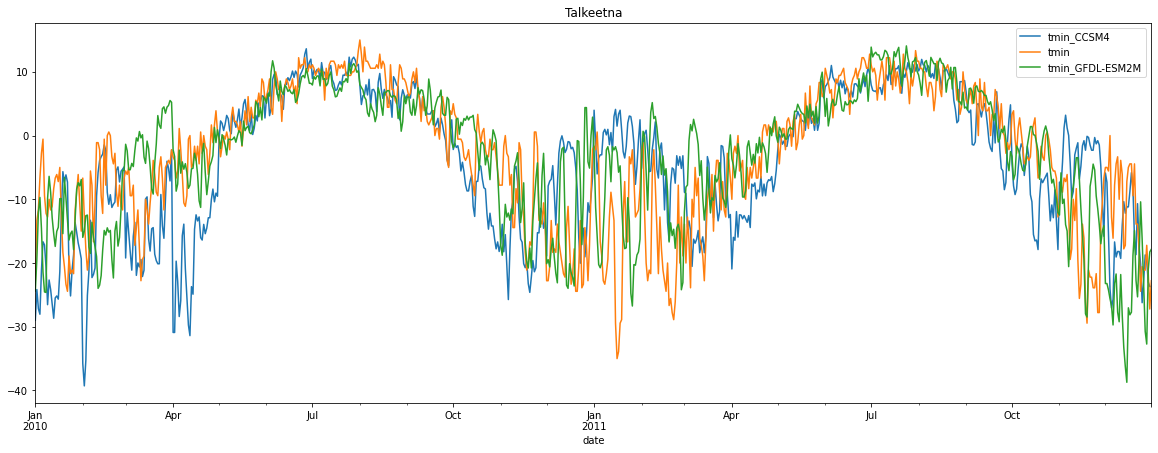

In [10]:
(
    obs_df[obs_df["location"] == "Talkeetna"]
    .set_index("date").loc["2010-01-01": "2011-12-31"]
    .reset_index()[["date", "tmin_CCSM4", "tmin", "tmin_GFDL-ESM2M"]]
    .plot(x="date", figsize=(20, 7), title="Talkeetna")
)(
    obs_df[obs_df["location"] == "Talkeetna"]
    .set_index("date").loc["2010-01-01": "2011-12-31"]
    .reset_index()[["date", "tmin_CCSM4", "tmin", "tmin_GFDL-ESM2M"]]
    .plot(x="date", figsize=(20, 7), title="Talkeetna")
)

<AxesSubplot:title={'center':'Talkeetna'}, xlabel='date'>

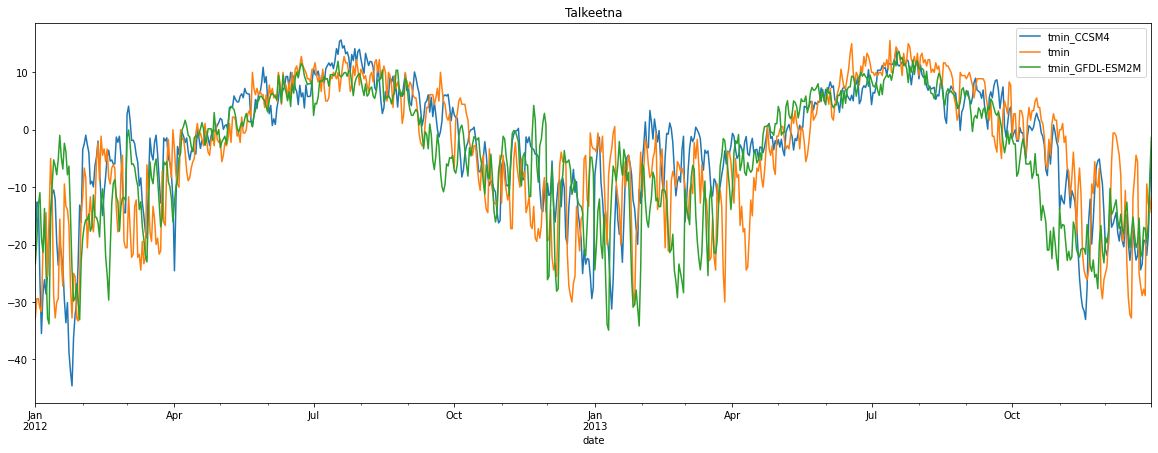

In [11]:
(
    obs_df[obs_df["location"] == "Talkeetna"]
    .set_index("date").loc["2012-01-01": "2013-12-31"]
    .reset_index()[["date", "tmin_CCSM4", "tmin", "tmin_GFDL-ESM2M"]]
    .plot(x="date", figsize=(20, 7), title="Talkeetna")
)

As you would expect - broad model agreement but nothing close to daily agreement.

### How long does it take to load the data?

Current pipeline is reading in each dataset twice as it iterates over years. Hoe long does it take to just load all of the data for a particular year using `xarray.open_mfdataset`? Also how does this compare to the time taken to copy it to scratch space and then open it? Will use a simple `min()` operation to benchmark.

In [20]:
from pathlib import Path


met_dir = Path("/Data/Base_Data/Climate/AK_NCAR_12km/met")
tmp_fn = "{}_{}_BCSD_met_{}.nc4"
model = "CCSM4"
scenario = "rcp45"

fps = [met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year)) for year in range(1950, 2010)]

Reading from Poseidon:

In [24]:
import xarray as xr


ds = xr.open_mfdataset(fps)

In [27]:
%time test = ds["tmin"].min(axis=0).compute()

/home/UA/kmredilla/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/reductions.py:586: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 38.7 s, sys: 5.95 s, total: 44.7 s
Wall time: 1min 48s


Wow that is not too bad. Going to try changing the read/compute strategy up a bit in the pipeline.

#### Equal historical values between future scenarios?

**Question - are the data for different scenarios of the same model have equal values for "historical" period before the emissions scenarios kick in?**

Iterate over the models and read in a sample time slice for the same time and compare.

In [10]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import luts


def compare_scenarios(year):
    met_dir = Path("/workspace/Shared/Tech_Projects/NCAR_AK/met")
    tmp_fn = "{}_{}_BCSD_met_{}.nc4"

    date = f"{year}-01-01"

    results = []
    for model in luts.models:
        model_result = {"model": model}
        for varname in ["pcp", "tmin", "tmax"]:
            with xr.open_dataset(met_dir.joinpath(model, "rcp45", tmp_fn.format(model, "rcp45", year))) as ds45:
                rcp45_arr = ds45[varname].sel(time=date)

            with xr.open_dataset(met_dir.joinpath(model, "rcp85", tmp_fn.format(model, "rcp85", year))) as ds85:
                rcp85_arr = ds85[varname].sel(time=date)

            model_result[varname] = np.array_equal(rcp45_arr, rcp85_arr, equal_nan=True)
        results.append(model_result)
    results_df = pd.DataFrame(results)
    print(results_df)


Just poking around a few different years, there appear to be some inconsistencies. Looks like for 1950, `CCSM4` has the same data for `tmin`, but nothing else:

In [11]:
compare_scenarios(1950)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False   True  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


Found another year where data match for `tmin`, for `HadGEM2-ES`, but nothing else:

In [12]:
compare_scenarios(1985)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False   True  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


But it seems that the arrays don't match for any models for other years:

In [13]:
compare_scenarios(1990)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


In [14]:
compare_scenarios(1995)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


In [15]:
compare_scenarios(1967)

           model    pcp   tmin   tmax
0      ACCESS1-3  False  False  False
1        CanESM2  False  False  False
2          CCSM4  False  False  False
3  CSIRO-Mk3-6-0  False  False  False
4     GFDL-ESM2M  False  False  False
5     HadGEM2-ES  False  False  False
6         inmcm4  False  False  False
7         MIROC5  False  False  False
8     MPI-ESM-MR  False  False  False
9      MRI-CGCM3  False  False  False


### "degree days below the curve" testing

This section explores the idea of counting degree days under the curve, or something like it, for an estimate of cooling.

In [49]:
import numpy as np
import xarray as xr
from pathlib import Path
from itertools import product

In [26]:
met_dir = Path("/workspace/Shared/Tech_Projects/NCAR_AK/met")
tmp_fn = "{}_{}_BCSD_met_{}.nc4"

In [28]:
model = "ACCESS1-3"
scenario = "hist"

In [175]:
ds = xr.open_mfdataset([
    met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year))
    for year in range(1980, 2010)
])

In [196]:
test_fall_arr = []
for year in range(1980, 2010):
    winter_tmin = ds["tmin"].sel(
        time=slice(f"{year - 1}-07-01", f"{year}-06-30")
    ).values
    test_fall_arr.append(np.flipud(np.apply_along_axis(fall_cooling, 0, winter_tmin)))
test_fall_arr = np.array(test_fall_arr)

In [186]:
nodata_mask = np.broadcast_to(np.flipud(np.isnan(winter_tmin[0])), test_fall_arr.shape)

Plot the mean degree days under the curve for ACCESS1-3 historical, 1980-2010

In [213]:
mean_arr = test_fall_arr.mean(axis=0)
mean_arr[np.flipud(np.isnan(winter_tmin[0]))] = np.nan
mean_arr[mean_arr > 70] = np.nan

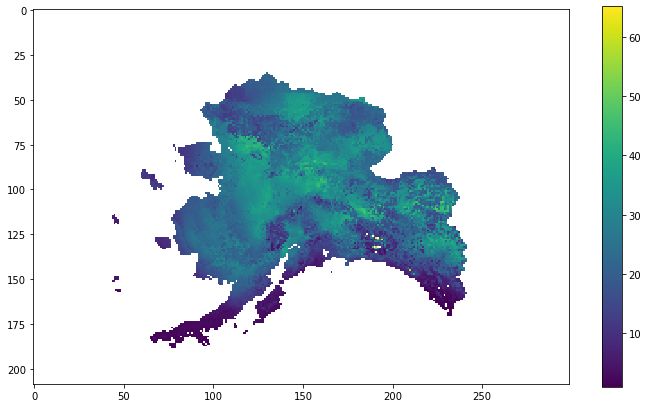

In [216]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(12, 7))

plt.imshow(mean_arr, interpolation="none")
plt.colorbar()

In [ ]:
# pulling som data from Nancy's spreadsheet

